This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np
import geopandas as gpd
import rasterio as rio
import censusdata
from rasterstats import zonal_stats

import optuna
import sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [10]:
df, basin_idx, basins, coords = read_data(
    file_dir='../data/hierarchical_septics_v7.csv',
    cols=['ppt_2021', 'hydraulic_c','median_hse', 'slope'], 
    is_balanced=True, 
    hierarchy_type='county'
)

balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# Baseline Comparison

In [11]:
train_x, test_x, train_y, test_y = train_test_split(
    df[['ppt_2021_norm', 'hydraulic_c_norm', 'median_hse_norm', 'slope_norm', 'age_median', 'income_median']], 
    df['sewageSystem_enc'], 
    test_size=0.2, 
    random_state=42
)

In [12]:
rs = 100
tune = 100

1. Water model: precipitation

In [6]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values)

    # global model parameters
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + ppt * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, ppt, sigma_c, mu_c, ppt_sig, ppt_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1215 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [7]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 54.33905989024099 ± 0.044548762906507236%


2. Soil model

In [8]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)

    # global model parameters
    hydr_mu = pm.Normal("hydr_mu", mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hydr * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hydr, sigma_c, mu_c, hydr_sig, hydr_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1351 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [9]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 54.51413743736579 ± 0.06003647171705542%


3. Topo model: elevation/slope

In [6]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    slope_d = pm.Data('slope_d', df.slope_norm.values)

    # global model parameters
    slope_beta = pm.HalfNormal('slope_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    slope = pm.Exponential('slope', lam=slope_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + slope * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [slope_beta, mu_c, sigma_c, slope, c]


Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 2038 seconds.


In [7]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 51.2486815658023 ± 0.09883223342198749%


4. Socio-economic model: median housing value

In [12]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hse * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hse, sigma_c, mu_c, hse_sig]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1113 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [13]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 51.79561361647975 ± 0.0614130242954866%


5. Full model

In [5]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    # water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)
    slope_d = pm.Data('slope_d', df.slope_norm.values)

    # global model parameters
    # wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_mu = pm.Normal("hydr_mu", mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    slope_beta = pm.HalfNormal('slope_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    # wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig)
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    slope = pm.Exponential('slope', lam=slope_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    # + wtr_dist * water_d 
                                    + ppt * ppt_d
                                    + hydr * hydr_d
                                    + hse * hse_d
                                    + slope * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

fitting full pooled Bayesian model...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ppt_mu, ppt_sig, hydr_mu, hydr_sig, hse_sig, slope_beta, mu_c, sigma_c, ppt, hydr, hse, slope, c]


Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1639 seconds.


In [7]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

Sampling: [failures]


Sampling: [failures]


Sampling: [failures]


Sampling: [failures]


Sampling: [failures]


accuracy is: 55.08756393162052 ± 0.05988267824043235%


In [37]:
# Get inference data for each state
def get_inference_data(indep_srcs, state_id):
    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster mean value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            
            # convert to slope
            if indep_var == 'slope':
                array = np.where(array == 32767, np.nan, array)
                res = src.res[0]  # pixel resolution in degrees
                elevation_deg = np.degrees(np.arctan(array / np.sqrt(res**2 + res**2)))
                slope_x, slope_y = np.gradient(elevation_deg, res, res)
                array = np.degrees(np.arctan(np.sqrt(slope_x**2 + slope_y**2)))

            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='median'))
        
        var_name = f'{indep_var}_median'
        state_bdry[var_name] = zones['median']

    # Get housing value
    acs_dict_list = [
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B25077_001E','col_name': 'hse_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B06002_001E','col_name': 'age_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B07411_001E','col_name': 'income_median'}
    ]    

    for acs_dict in acs_dict_list:
        acs = (censusdata.download(
            acs_dict['type'],
            acs_dict['year'], 
            censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
        ).reset_index().rename(columns={acs_dict['code']: acs_dict['col_name']}))

        for i, row in acs.iterrows():
            county = (str(row['index'])
                        .split(',')[0]
                        .split('County')[0]
                        .strip())

            acs.loc[i, 'County'] = county
        
        for i, row in state_bdry.iterrows():
            try:
                mean = acs[acs['County'] == row['NAME']][acs_dict['col_name']].item()
                state_bdry.loc[i, acs_dict['col_name']] = mean
            except:
                state_bdry.loc[i, acs_dict['col_name']] = 0

    return state_bdry

# Compute probability of failure for pooled model
def compute_risk_probability_pooled(gdf, attr_params, sampling_sz=100, runs=5):
    """Compute risk probability (and its uncertainty) over (sampling_sz * n) runs"""
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        
        # Average across chains and draws
        x_params = {
            'ppt': pm.Normal.dist(mu=attr_params['ppt_mu'].mean().item(), sigma=pm.HalfNormal.dist(sigma=attr_params['ppt_sig'].mean().item())),
            'hydr': pm.Normal.dist(mu=attr_params['hydr_mu'].mean().item(), sigma=pm.HalfNormal.dist(sigma=attr_params['hydr_sig'].mean().item())),
            'hse': pm.Normal.dist(sigma=pm.HalfNormal.dist(sigma=attr_params['hse_sig'].mean().item())),
            'slope': pm.Exponential.dist(lam=abs(attr_params['slope_beta'].mean().item()))
        }
        failure_theta = pm.math.sigmoid(
            attr_params['c'].mean().item()
            + pm.draw(x_params['ppt'], draws=sampling_sz).mean() * row['ppt_median']
            + pm.draw(x_params['hydr'], draws=sampling_sz).mean() * row['soil_median']
            + pm.draw(x_params['hse'], draws=sampling_sz).mean() * row['hse_median']
            + pm.draw(x_params['slope'], draws=sampling_sz).mean() * row['slope_median']
        )
        
        risks = []
        failures = pm.Bernoulli.dist(failure_theta)
        for j in range(runs):
            risk = pm.draw(failures, draws=sampling_sz)
            risks.append(risk.mean())
        
        risk_mean = np.array(risks).mean()
        risk_std = np.array(risks).std()
        gdf.loc[i, 'risk_mean'] = risk_mean
        gdf.loc[i, 'risk_std'] = risk_std
    
    return gdf

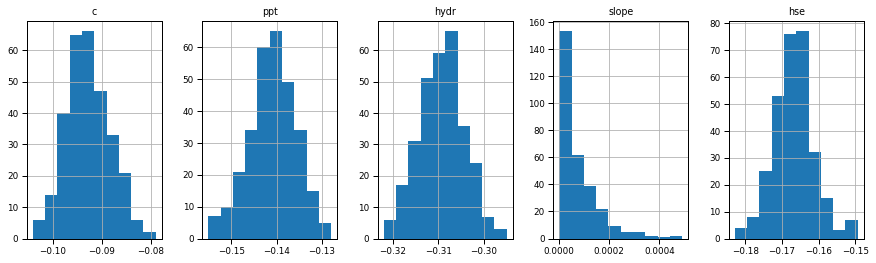

In [18]:
# Plot posterior
posterior_params = ['c', 'ppt', 'hydr', 'slope', 'hse']
f, ax = plt.subplots(1,5, figsize=(15,4))
for posterior_idx, posterior_param in enumerate(posterior_params):
    trace['posterior'][posterior_param].to_dataframe().hist(ax=ax[posterior_idx])
    ax[posterior_idx].set_title(posterior_param)

In [9]:
# # Save graph for figure 8
# graph = pm.model_graph.model_to_graphviz(model)
# graph.render(filename='../docs/pooled')

# # Edit the graph
# from graphviz import Source
# filename='../docs/pooled'
# graph = Source.from_file(filename)
# graph.render(filename=filename)

'../docs/pooled.pdf'

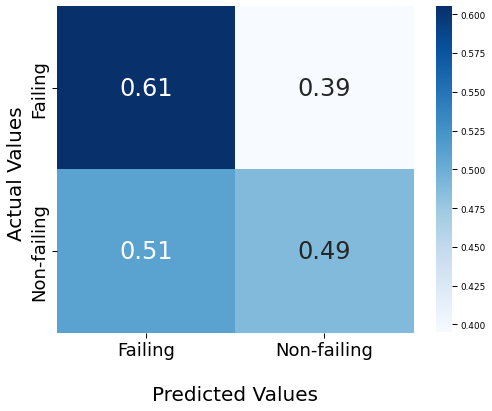

In [10]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l0.pdf')

## Hyperparameter Optimization

In [10]:
# hyperparameter optimization with optuna
def objective(trial, classifier_name):
    assert classifier_name in ['SVC']
    if classifier_name == 'SVC':
        svc_deg = trial.suggest_int('svc_deg', 1, 10)
        svc_c = trial.suggest
        classifier_obj = SVC(degree=svc_deg, gamma='auto')
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
# Optimize SVC
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='SVC'), n_trials=10)

## Optimized Baseline Analysis

### b) Logistic Regressor

accuracy for LR: 57.37810945273631 ± 0.0 %


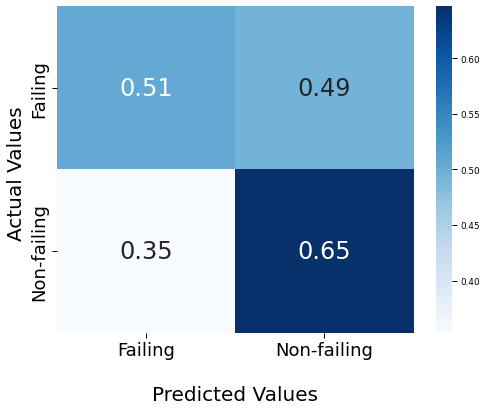

In [11]:
from sklearn.linear_model import LogisticRegression

accs = []
for i in range(5):
    lr = LogisticRegression()
    lr.fit(train_x, train_y)
    pred = lr.predict(test_x)
    acc = (pred == test_y).sum() / len(pred)
    accs.append(acc)

print(f'accuracy for LR: {np.array(accs).mean() * 100} ± {np.array(accs).std() * 100} %')

plot_confusion(test_y, pred, title='', savedir='../docs/confusion_lr.pdf')

### c) SVC

accuracy for SVC: 54.57462686567164 ± 0.0 %


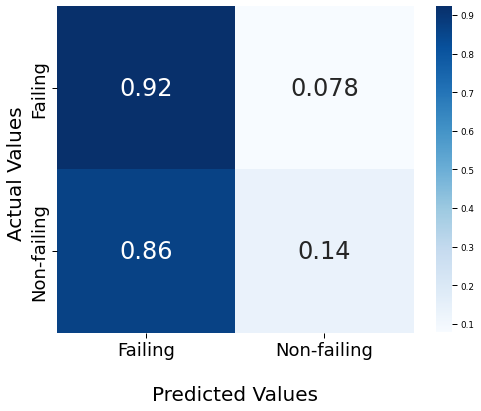

In [8]:
# SVC
accs = []
for i in range(5):
    svc_clf = SVC(max_iter=100)
    svc_clf.fit(train_x, train_y)
    svc_y_pred = svc_clf.predict(test_x)
    acc = (svc_y_pred == test_y).sum() / len(svc_y_pred)
    accs.append(acc)

print(f'accuracy for SVC: {np.array(accs).mean() * 100} ± {np.array(accs).std() * 100} %')

plot_confusion(test_y, svc_y_pred, title='', savedir='../docs/confusion_svc.pdf')

### d) RF

accuracy for RF: 62.600497512437805 ± 0.3000565114303147 %


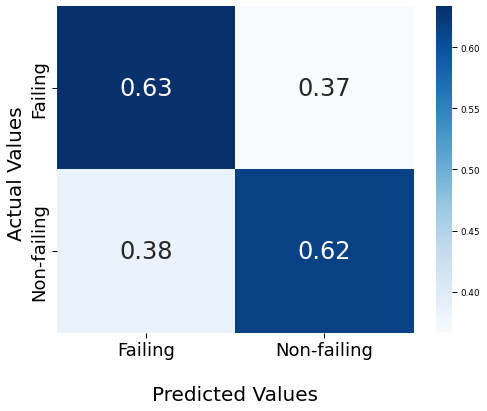

In [13]:
from sklearn.ensemble import RandomForestClassifier

# RF
accs = []
for i in range(5):
    rf_clf = RandomForestClassifier(max_depth=2)
    rf_clf.fit(train_x, train_y)
    rf_y_pred = rf_clf.predict(test_x)
    acc = (rf_y_pred == test_y).sum() / len(rf_y_pred)
    accs.append(acc)

print(f'accuracy for RF: {np.array(accs).mean() * 100} ± {np.array(accs).std() * 100} %')

plot_confusion(test_y, rf_y_pred, title='', savedir='../docs/confusion_rf.pdf')